In [8]:
%matplotlib inline
import os
import json
import itertools
from glob import glob
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn
import pandas
import yaml
from intervaltree import IntervalTree

from phasm.io import gfa

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_context('paper')
seaborn.set_style("whitegrid")

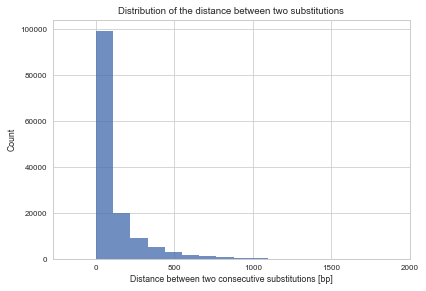

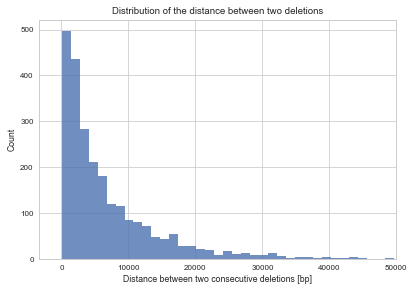

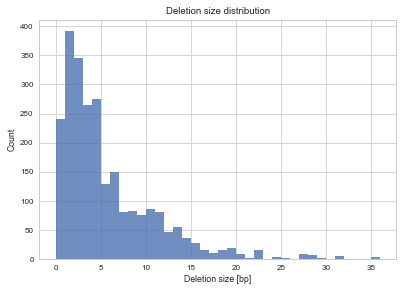

In [32]:
genome_mutations = glob(os.path.join(BASE_DIR, "genomes/**/*_mutations.json"), recursive=True)
genome_mutations

subst_distances = []
del_distances = []
del_sizes = []

for mut_file in genome_mutations:
    with open(mut_file) as f:
        mutations = json.load(f)
        
        for chr_mut in mutations:
            last_subst = -1
            last_del = -1
            for mut in chr_mut:
                if mut['mut_type'] == "MutationType.SUBSTITUTION":
                    if last_subst != -1:
                        dist = mut['haplo_pos'] - last_subst
                        subst_distances.append(dist)
                        
                    last_subst = mut['haplo_pos']
                else:
                    if last_del != -1:
                        dist = mut['haplo_pos'] - last_del
                        del_distances.append(dist)
                    
                    last_del = mut['haplo_pos']
                    del_sizes.append(-mut['size'])
                    
plt.figure()
#plt.hist(subst_distances, bins=100)
seaborn.distplot(subst_distances, kde=False, hist_kws={"alpha": 0.8})
plt.xlabel('Distance between two consecutive substitutions [bp]')
plt.ylabel('Count')
plt.xlim(xmax=2000)
plt.title('Distribution of the distance between two substitutions')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'subst-dist.png'), dpi=256, transparent=True)

plt.figure()
#plt.hist(del_distances, bins=100)
seaborn.distplot(del_distances, kde=False, hist_kws={"alpha": 0.8})
plt.xlabel('Distance between two consecutive deletions [bp]')
plt.ylabel('Count')
plt.title('Distribution of the distance between two deletions')
plt.xlim(xmax=50000)
plt.savefig(os.path.join(BASE_DIR, 'figures', 'del-dist.png'), dpi=256, transparent=True)

plt.figure()
bin_size = 1
bins = range(0, max(del_sizes)+bin_size, bin_size)
seaborn.distplot(del_sizes, kde=False, bins=bins, hist_kws={"alpha": 0.8})
plt.xlabel('Deletion size [bp]')
plt.ylabel('Count')
plt.title('Deletion size distribution')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'deletion-size-dist.png'), dpi=256, transparent=True)

In [43]:
mut_data = []

for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    if coverage != 60:
        continue
        
    reads_meta_f = os.path.join(asm_folder, "00_reads", "ploidy{}-{}x.json".format(ploidy, coverage))
    if not os.path.isfile(reads_meta_f):
        continue
        
    with open(reads_meta_f) as f:
        reads_meta = json.load(f)
    
    interval_trees = defaultdict(IntervalTree)
    
    for readid, meta in reads_meta.items():
        chromosome_copy = int(meta['chromosome'][-1])
        start = meta['start_pos']
        end = meta['start_pos'] + meta['len']
        
        interval_trees[chromosome_copy][start:end] = readid
        
    # Read reads used in the assembly graph
    layout_gfa = os.path.join(asm_folder, "02_layout", "assembly_graph.gfa")
    with open(layout_gfa) as f:
        segments = gfa.gfa2_parse_segments_with_fragments(f)
    
    graph_read_set = set()
    for sid, segment in segments.items():
        if isinstance(segment, gfa.MergedFragment):
            for oriented_read in segment.reads:
                graph_read_set.add(oriented_read[:-1])
        else:
            graph_read_set.add(sid)
            
    genome_mutations = glob(
        os.path.join(BASE_DIR, "genomes/ploidy-{}/**/*_mutations.json".format(ploidy)), 
        recursive=True
    )[0]
    
    with open(genome_mutations) as f:
        mutations_meta = json.load(f)
        
    grouped_by_refpos = defaultdict(dict)
        
    for copy, haplotype_mut in enumerate(mutations_meta):
        for mut in haplotype_mut:
            grouped_by_refpos[mut['ref_pos']][copy] = mut
            
    for ref_pos, haplotype_mut in grouped_by_refpos.items():
        covering_reads = set()
        for copy, mut in haplotype_mut.items():
            covering_reads.update(iv.data for iv in interval_trees[copy][mut['haplo_pos']])
            
        graph_and_covering = covering_reads & graph_read_set
        mut_data.append({
            'ploidy': ploidy,
            'coverage': coverage,
            'haplo_pos': int(mut['haplo_pos']),
            'covering_reads': len(covering_reads),
            'in_graph': len(graph_and_covering) > 0
        })
            
df = pandas.DataFrame(mut_data)

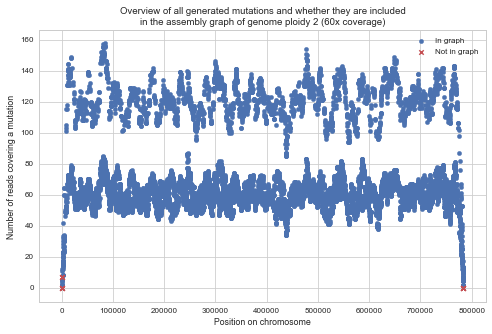

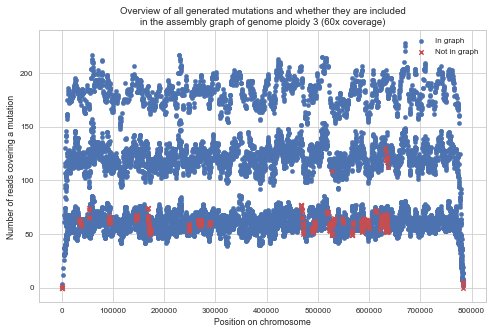

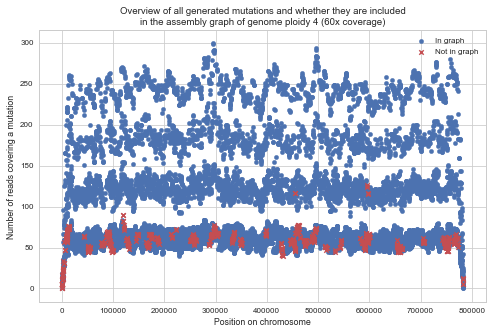

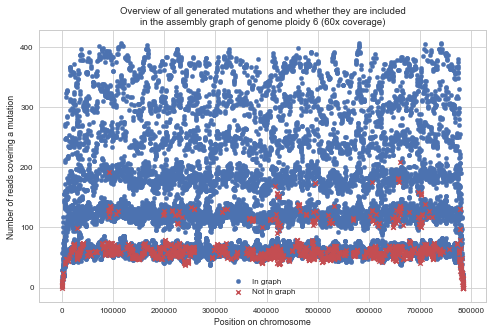

In [44]:
blue, green, red = seaborn.color_palette(n_colors=3)

for ploidy, coverage in itertools.product([2, 3, 4, 6, 8], [60]):
    subdf = df.query('(ploidy == @ploidy) and (coverage == @coverage)')
    
    if len(subdf) == 0:
        continue
    
    plt.figure()
    ax = subdf[subdf['in_graph'] == True].plot.scatter(
        x="haplo_pos", y="covering_reads", color=blue, label="In graph", figsize=(8, 5))
    subdf[subdf['in_graph'] == False].plot.scatter(
        x="haplo_pos", y="covering_reads", color=red, marker='x', label="Not in graph", ax=ax)
    plt.xlabel('Position on chromosome')
    plt.ylabel('Number of reads covering a mutation')
    plt.title('Overview of all generated mutations and whether they are included\n'
              'in the assembly graph of genome ploidy {} ({}x coverage)'.format(ploidy, coverage))
    plt.savefig(os.path.join(BASE_DIR, 'figures', 'mut-graph-ploidy{}-{}x.png'.format(ploidy, coverage)),
                transparent=True, dpi=256)


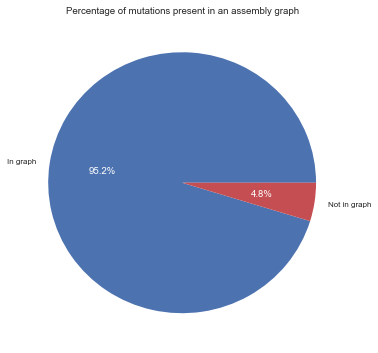

In [45]:
plt.figure(figsize=(6, 6))
in_graph = len(df[df['in_graph'] == True])
not_in_graph = len(df[df['in_graph'] == False])

_, _, percentages = plt.pie([in_graph, not_in_graph], labels=["In graph", "Not in graph"], 
                            colors=[blue, red], autopct="%1.1f%%")

for text in percentages:
    text.set_color('white')
    
plt.title("Percentage of mutations present in an assembly graph")
plt.savefig(os.path.join(BASE_DIR, 'figures', 'total-mutations-pie.png'), transparent=True, dpi=256)
